In [72]:
import sympy as syp

In [73]:
x, y = syp.var('x y')

In [74]:
u0 = syp.sin(7.0*x - 3.0*y) + 2.0*syp.cos(2.0*x + 6.0*y)
u0

sin(7.0*x - 3.0*y) + 2.0*cos(2.0*x + 6.0*y)

In [75]:
f = -(u0.diff(x, 2) + u0.diff(y, 2))
print(f.expand())

58.0*sin(7.0*x - 3.0*y) + 80.0*cos(2.0*x + 6.0*y)


In [76]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg
import time


# Размеры области
xmin, xmax = 0.0, 1.0
ymin, ymax = 0.0, np.sqrt(2.0)

# Точное решение


def u_exact(x, y):
    return np.sin(7.0*x - 3.0*y) + 2.0*np.cos(2.0*x + 6.0*y)

# Неоднородность в уравнении


def f(x, y):
    return 58.0*np.sin(7.0*x - 3.0*y) + 80.0*np.cos(2.0*x + 6.0*y)

# Граничные условия


def phi_L(y):
    return u_exact(xmin, y)


def phi_R(y):
    return u_exact(xmax, y)


def phi_B(x):
    return u_exact(x, ymin)


def phi_T(x):
    return u_exact(x, ymax)

In [77]:
# Характерное разбиение
h0 = 0.002
lx = xmax - xmin
ly = ymax - ymin

nx = int(np.round(lx / h0)) + 1
ny = int(np.round(ly / h0)) + 1

beg_1 = time.time()

# Узлы сетки
x, hx = np.linspace(xmin, xmax, nx, retstep=True)
y, hy = np.linspace(ymin, ymax, ny, retstep=True)
X, Y = np.meshgrid(x, y, indexing='ij')

N = np.arange(0, X.size, dtype=int).reshape((nx, ny))
print(N)

[[     0      1      2 ...    705    706    707]
 [   708    709    710 ...   1413   1414   1415]
 [  1416   1417   1418 ...   2121   2122   2123]
 ...
 [352584 352585 352586 ... 353289 353290 353291]
 [353292 353293 353294 ... 353997 353998 353999]
 [354000 354001 354002 ... 354705 354706 354707]]


In [78]:
print(x.shape)
print(y.shape)
print(X.shape)
print(Y.shape)
print(N.shape)

(501,)
(708,)
(501, 708)
(501, 708)
(501, 708)


In [79]:
cx = -((nx - 1) / lx)**2  # -1/hx**2
cy = -((ny - 1) / ly)**2  # -1/hy**2
bb = -2.0 * (cx + cy)  # (2/hx**2 + 2/hy**2)
print(cx, cy, bb)

-250000.0 -249924.49999999994 999848.9999999999


In [80]:
R1 = N[1:-1, 1:-1].flatten()  # inner mesh of N
C1 = N[1:-1, 1:-1].flatten()  # inner mesh of N
V1 = np.full_like(R1, bb)  # array of size R1 with all value bb
print(R1.shape, C1.shape, V1.shape)
# concatenate these vectors we get a diagonal in final matrix
print(R1[:10])
print(C1[:10])

(352294,) (352294,) (352294,)
[709 710 711 712 713 714 715 716 717 718]
[709 710 711 712 713 714 715 716 717 718]


In [81]:
R2 = N[1:-1, 1:-1].flatten()  # inner mesh of N
C2 = N[0:-2, 1:-1].flatten()  # inner lower mesh of N
V2 = np.full_like(R2, cx)  # array of size R2 with all value cx
print(R2.shape, C2.shape, V2.shape)
# concatenate these vectors we get a lower diagonal in final matrix
print(R2[:10])
print(C2[:10])

(352294,) (352294,) (352294,)
[709 710 711 712 713 714 715 716 717 718]
[ 1  2  3  4  5  6  7  8  9 10]


In [82]:
R3 = N[1:-1, 1:-1].flatten()  # inner mesh of N
C3 = N[2:, 1:-1].flatten()  # inner upper mesh of N
V3 = np.full_like(R3, cx)  # array of size R3 with all value cx
print(R3.shape, C3.shape, V3.shape)
# concatenate these vectors we get a upper diagonal in final matrix
print(R3[:10])
print(C3[:10])

(352294,) (352294,) (352294,)
[709 710 711 712 713 714 715 716 717 718]
[1417 1418 1419 1420 1421 1422 1423 1424 1425 1426]


In [83]:
R4 = N[1:-1, 1:-1].flatten()  # inner mesh of N
C4 = N[1:-1, 0:-2].flatten()  # inner left mesh of N
V4 = np.full_like(R4, cy)  # array of size R4 with all value cy
print(R4.shape, C4.shape, V4.shape)
print(R4[:10])
print(C4[:10])

(352294,) (352294,) (352294,)
[709 710 711 712 713 714 715 716 717 718]
[708 709 710 711 712 713 714 715 716 717]


In [84]:
R5 = N[1:-1, 1:-1].flatten()  # inner mesh of N
C5 = N[1:-1, 2:].flatten()  # inner right mesh of N
V5 = np.full_like(R5, cy)  # array of size R5 with all value cy
print(R5.shape, C5.shape, V5.shape)
print(R5[:10])
print(C5[:10])

(352294,) (352294,) (352294,)
[709 710 711 712 713 714 715 716 717 718]
[710 711 712 713 714 715 716 717 718 719]


In [85]:
# lower boundary
R6 = N[0, :]
C6 = N[0, :]
V6 = np.ones_like(R6)  # array size 708 with all value 1
print(R6.shape, C6.shape, V6.shape)
print(R6[:10])
print(C6[:10])

(708,) (708,) (708,)
[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]


In [86]:
# upper boundary
R7 = N[-1, :]
C7 = N[-1, :]
V7 = np.ones_like(R7)  # array size 708 with all value 1
print(R7.shape, C7.shape, V7.shape)
print(R7[:10])
print(C7[:10])

(708,) (708,) (708,)
[354000 354001 354002 354003 354004 354005 354006 354007 354008 354009]
[354000 354001 354002 354003 354004 354005 354006 354007 354008 354009]


In [87]:
# left boundary
R8 = N[1:-1, 0]
C8 = N[1:-1, 0]
V8 = np.ones_like(R8)  # array size 501 - 2 with all value 1
print(R8.shape, C8.shape, V8.shape)
print(R8[:10])
print(C8[:10])

(499,) (499,) (499,)
[ 708 1416 2124 2832 3540 4248 4956 5664 6372 7080]
[ 708 1416 2124 2832 3540 4248 4956 5664 6372 7080]


In [88]:
# right boundary
R9 = N[1:-1, -1]
C9 = N[1:-1, -1]
V9 = np.ones_like(R9)  # array size 501 - 2 with all value 1
print(R8.shape, C8.shape, V8.shape)
print(R9[:10])
print(C9[:10])

(499,) (499,) (499,)
[1415 2123 2831 3539 4247 4955 5663 6371 7079 7787]
[1415 2123 2831 3539 4247 4955 5663 6371 7079 7787]


In [89]:
z = np.zeros(3)
a = np.full_like(z, 1)
b = np.full_like(z, 2)
c = np.full_like(z, 3)
np.concatenate((z, a, b, c))

array([0., 0., 0., 1., 1., 1., 2., 2., 2., 3., 3., 3.])

In [90]:
row = np.concatenate((R1,
                      R2, R3, R4, R5,
                      R6, R7, R8, R9))
col = np.concatenate((C1,
                      C2, C3, C4, C5,
                      C6, C7, C8, C9))
val = np.concatenate((V1,
                      V2, V3, V4, V5,
                      V6, V7, V8, V9))

In [91]:
A = sp.csc_matrix((val, (row, col)))

F = f(X, Y)
F[0, :] = phi_L(Y[0, :])
F[-1, :] = phi_R(Y[-1, :])
F[:,  0] = phi_B(X[:, 0])
F[:, -1] = phi_T(X[:, -1])

end_1 = time.time()

In [92]:
beg_2 = time.time()
u = sp.linalg.spsolve(A, F.ravel())
u = u.reshape(X.shape)
end_2 = time.time()

print('fill matrices:  %.5f sec' % (end_1 - beg_1))
print('linalg.spsolve: %.5f sec' % (end_2 - beg_2))

fill matrices:  0.46262 sec
linalg.spsolve: 20.27088 sec


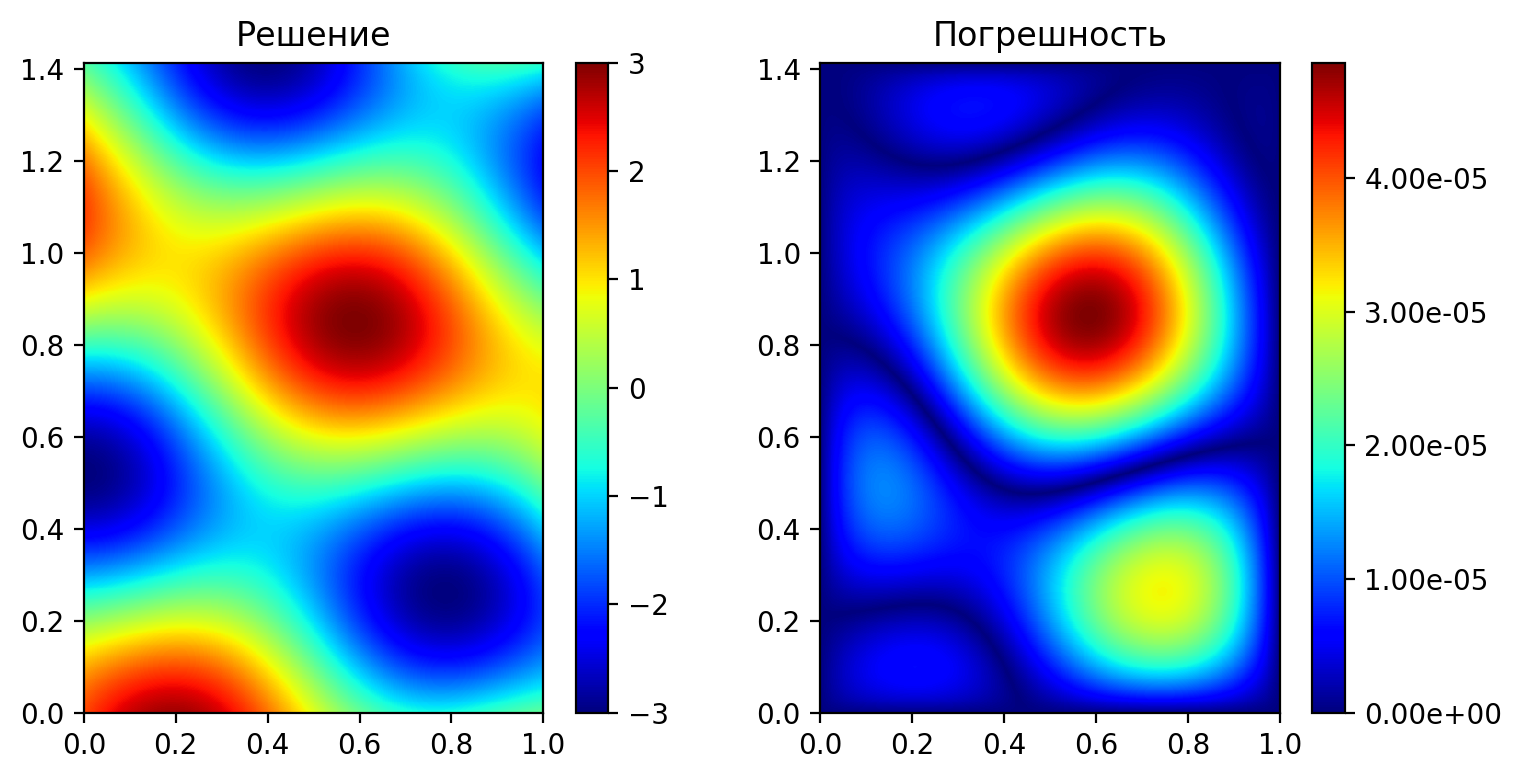

In [93]:
fig = plt.figure(dpi=200, figsize=(8.0, 4.0))

ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

options = {'cmap': 'jet',
           'aspect': 'equal',
           'origin': 'lower',
           'extent': [xmin - 0.5 * hx, xmax + 0.5 * hx,
                      ymin - 0.5 * hy, ymax + 0.5 * hy],
           'interpolation': 'nearest'}

ax1.set_title('Решение')
ax1.set_xlim(xmin, xmax)
ax1.set_ylim(ymin, ymax)
img1 = ax1.imshow(u.T, **options)
fig.colorbar(img1, ax=ax1)

ax2.set_title('Погрешность')
ax2.set_xlim(xmin, xmax)
ax2.set_ylim(ymin, ymax)
img2 = ax2.imshow(np.abs(u - u_exact(X, Y)).T, **options)
fig.colorbar(img2, ax=ax2, format='%.2e')

fig.tight_layout()
plt.show()